# RL implementation

In [28]:
import os, sys
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from itertools import product
from IPython.display import clear_output
from scipy.signal import convolve2d

plt.rcParams["figure.figsize"] = (20,8)

In [2]:
import text_flappy_bird_gym

**Important :** 

Since the game has no specific end policy (unless the agent dies), it becomes computationally expensive to train the agent for longer and to test it since it can potentially reach infinite scores. On the test runs, after 2000 training episodes, the agent was able to reach scores of 100'000 on average. Therefore, we will set an maximum target score.

According to <a href="https://www.speedrun.com/flappybird/full_game?h=Highscore_EmulatorWeb-Original_Game&x=ndx394vd-onvm0mnm.9qj25wo1">the Speed Run website</a>, the highest score ever at Flappy Bird (or one of its emulators) is 7847. For good measure, we will set the **target high score to 8000**.

### Environment

The following code displays the text environment.
At every step, the code chooses a random action. Hence, you'll see that the performance of this code is terrible.

In [3]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

while True:
    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(.1) # FPS
    
    clear_output(wait=True)
    
    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[                    ]
[                    ]
[                    ]
[                    ]
[     *         |    ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=9,dy=3)


## Method 1 : Q-learning: Off-policy TD Control

This implementation is based on the eponymous section 6.5 from __Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.__

First, we need to determine the possible states.

In this environment, we will consider the states as the tuples (x, y) where x and y are respectively the longitudinal and vertical distances to the center of the closest upcoming pipe gap.

Given the setup of the environment :
- x can take integer values from 0 to width (=20)
- y can take integer values from -height (=-15) to height (=15)

In [10]:
class Q_learning_flappy_bird_v1():
    def __init__(self, env, width, height, pipe_gap):
        
        self.width = width
        self.height = height
        self.pipe_gap = pipe_gap
        self.env = env
        self.max_score = 2000
        
        n_x_states = self.width
        n_y_states = 2 * self.height
        self.state_space_x = list(range(self.width))
        self.state_space_y = list(range(-self.height, self.height))
        
        self.Q = np.random.rand(n_x_states, n_y_states, 2) * 10
        # Terminal conditions
        self.Q[0, :, :] = 0
        
        self.train_iteration = -1
        
        self.score_history = []
        self.death_causes = []
        self.reward_history = []
        
        self.accuracy_history = []
        
        self.death_cause_play = None
        self.score_play = None
        self.reward_play = None
    
    
    def _distance_to_state(self, x, y):
        """
        Returns the index of the state given distances x and y.
        """
        state_x = self.state_space_x.index(x)
        state_y = self.state_space_y.index(y)
        return state_x, state_y
    
    
    def _argmax(self, q_values):
        """
        Returns the argmax equiprobably in case of ties.
        """
        top = float("-inf")
        
        ties = []
        for i in range(len(q_values)):
            if q_values[i] == top:
                ties.append(i)
            elif q_values[i] > top:
                ties = [i]
                top = q_values[i]
        
        ind = np.random.choice(ties)
        return ind
    
    def _step_size(self, alpha, i, i_lim=1000):
        """
        Defines the step size choosing policy to assure convergence.
        """
        if (i > i_lim):
            return alpha / ((i - i_lim) ** 1)
        else:
            return alpha
    
    
    def _epsilon_decay(self, epsilon, i, i_lim=1000):
        if i <= i_lim:
            return epsilon
        return epsilon / ((i - i_lim) ** 1)
    
    
    def _epsilon_greedy(self, epsilon, x, y):
        """
        Defines the epsilon-greedy policy of training.
        """
        random_number = np.random.random()
        if random_number < epsilon:
            action = self.env.action_space.sample()  # for an agent, action = agent.policy(observation)
        else:
            action = self._argmax(self.Q[x, y, :])
        
        return action
    
    def _render_game(self, i, top_score, sleep_time):
        """
        Renders the game with a certain sleep time (1/FPS)
        """
        os.system("clear")
        
        if i:
            print(f"Episode : {i+1}/{n_episodes}")
            
        print("Top score :", top_score)
        
        sys.stdout.write(self.env.render())
        
        if sleep_time:
            time.sleep(sleep_time) # FPS

        clear_output(wait=True)
    
    
    def _evaluate_distance_to_benchmark(self, Q_benchmark):
        benchmark_policy = np.argmax(Q_benchmark, axis=-1)
        current_policy = np.argmax(self.Q, axis=-1)
        
        accuracy = np.sum(benchmark_policy == current_policy)
        accuracy = accuracy / benchmark_policy.size
        
        return accuracy
    

    
    def train(self, n_episodes, alpha, epsilon, gamma, i_lim=1000, Q_benchmark=None, show_episodes=True):
        """
        Trains the Q-Learning model.
        """
        top_score = float("-inf")
        
        for i in range(n_episodes):
            self.train_iteration += 1
            
            obs = self.env.reset()
            x, y = obs[0]
            x, y = self._distance_to_state(x, y)
            
            cumulative_reward = 0
            
            while True:
                # Select next action
                decayed_epsilon = self._epsilon_decay(epsilon, self.train_iteration, i_lim=i_lim)
                action = self._epsilon_greedy(epsilon, x, y)

                # Apply action and return new observation of the environment
                obs, reward, done, _, info = self.env.step(action)
                x_, y_ = obs
                score = info['score']
                if score > top_score:
                    top_score = score
                
                # If we die, we set the reward to -100.
                if done:
                    reward = -100
                    if x == 0:
                        self.death_causes.append("Collision")
                    else:
                        self.death_causes.append("Floor")
                
                # If we reach the Max Score
                if score == self.max_score:
                    done = True
                    self.death_causes.append("Max score")
                        
                # If we manage to go through a gap, we get a reward of 10
                elif x==0 and not done:
                    reward = 1
                
                cumulative_reward += reward
                
                # Update the Q according to the Q-learning update equation
                step_size = self._step_size(alpha, self.train_iteration, i_lim=i_lim)
                self.Q[x, y, action] += step_size * (reward + gamma * np.max(self.Q[x_, y_, :]) - self.Q[x, y, action])
                
                # Update x and y
                x, y = x_, y_
                
                # Calculate accuracy with respect to benchmark
                if Q_benchmark is not None:
                    self.accuracy_history.append(self._evaluate_distance_to_benchmark(Q_benchmark))
                
                # Render the game
                if show_episodes:
                    self._render_game(i, top_score, 0)

                # If player is dead break
                if done:
                    break
            
            self.score_history.append(score)
            self.reward_history.append(cumulative_reward)

        self.env.close()
        
        return self
    
    
    def plot_training_rewards(self):
        plt.plot(self.reward_history)
        plt.xlabel("Training episodes")
        plt.ylabel("Rewards")
        
        plt.show()
    
    
    def play(self, display=True, sleep_time=0.1):
        obs = self.env.reset()
        x, y = obs[0]
        x, y = self._distance_to_state(x, y)
        self.reward_play = 0
        
        top_score = float("-inf")

        while True:
            # Select next action
            action = self._argmax(self.Q[x, y, :])

            # Apply action and return new observation of the environment
            obs, reward, done, _, info = self.env.step(action)
            x, y = obs
            
            score = info['score']
            if score > top_score:
                top_score = score

            
            if not done and x == 0:
                reward = 10
            elif done:
                reward = -100
            self.reward_play += reward
            
            if done and (score != self.max_score):
                if x == 0:
                    self.death_cause_play = "Collision"
                else:
                    self.death_cause_play = "Floor"
            
            
            #print(self.score_play)
            # Render the game
            if display:
                self._render_game(None, top_score, sleep_time)
            
            # Early breaking if the agent performs well and doesn't stop
            if score == self.max_score:
                done = True
                self.death_cause_play = "Max Score"

            # If player is dead break
            if done:
                self.score_play = info['score']
                break

        self.env.close()
        
        return self

In [543]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

q_learning_v1 = Q_learning_flappy_bird_v1(env=env, 
                                         width = width, 
                                         height = height, 
                                         pipe_gap = pipe_gap)

#### Example of training

In [437]:
n_episodes = 100
alpha = 0.1
epsilon = 0.1
gamma = 0.9

train_model = q_learning_v1.train(n_episodes=n_episodes,
                                  alpha=alpha,
                                  gamma=gamma,
                                  epsilon=epsilon)

Episode : 100/100
Top score : 9
Text Flappy Bird!
Score: 0
----------------------
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |             ]
[                    ]
[                    ]
[                    ]
[                |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[     *|         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=0,dy=9)


#### Do the rewards converge ?

In [457]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

In [458]:
alpha = 0.1
epsilon = .1
gamma = .9

train_episodes = 5000
n_agents = 100

rewards_array = []



for i in tqdm(range(n_agents)):
    q_learning = Q_learning_flappy_bird_v1(env=env, 
                                          width = width, 
                                          height = height, 
                                          pipe_gap = pipe_gap)
    
    q_learning = q_learning.train(n_episodes=train_episodes,
                                  alpha=alpha,
                                  epsilon=epsilon,
                                  gamma=gamma,
                                  show_episodes=False)
    
    rewards_array.append(q_learning.reward_history)

100%|█████████████████████████████████████████| 100/100 [10:12<00:00,  6.13s/it]


In [459]:
rewards_array = np.array(rewards_array)
rewards_array

array([[-91, -88, -89, ...,  62, -78,   2],
       [-88, -88, -88, ...,  12, 112, -29],
       [-88, -97, -94, ...,  22,  -8, -56],
       ...,
       [-88, -89, -88, ..., 492, -78, -74],
       [-88, -97, -88, ...,  12,  72, 182],
       [-88, -88, -88, ...,  32, -78, -68]])

In [460]:
q_learning.death_causes[-100:]

['Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Collision',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Collision',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Collision',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor',
 'Floor'

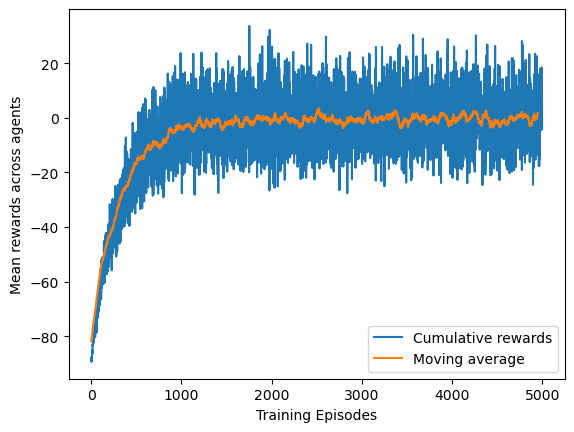

In [461]:
rewards_array = np.array(rewards_array)
mean_rewards_per_step = np.mean(rewards_array, axis=0)

window_size = 50
moving_average_scores = np.convolve(mean_rewards_per_step, np.ones(window_size), 'valid') / window_size

plt.plot(mean_rewards_per_step, label="Cumulative rewards")
plt.plot(moving_average_scores, label="Moving average")

plt.xlabel("Training Episodes")
plt.ylabel("Mean rewards across agents")

plt.legend()

plt.show()

The training rewards demonstrate a nice and steady convergence as we increase the training episodes.

### Examining the score with respect to the number of training episodes :

In this section, we investigate on the relationship between the number of training episodes and the median/mean score reached by the agent.

In [491]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

q_learning_v1 = Q_learning_flappy_bird_v1(env=env, 
                                          width = width, 
                                          height = height, 
                                          pipe_gap = pipe_gap)

In [492]:
alpha = 0.1
epsilon = 0.1
gamma = .9

start_n_episodes = 10
end_n_episodes = 3000
n_steps = 40

episodes_array = np.linspace(start_n_episodes, end_n_episodes, n_steps).astype(int)
episodes_array = [10, 30, 50, 75, 100, 250, 400, 700, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
episodes_increments = [start_n_episodes] + list(np.diff(episodes_array))

raw_results = []
median_scores = []
mean_scores = []
dict_scores = {}

for i, n_episodes in enumerate(episodes_increments):
    train_model = q_learning_v1.train(n_episodes=n_episodes,
                                      alpha=alpha,
                                      epsilon=epsilon,
                                      gamma=gamma,
                                      i_lim=2000,
                                      show_episodes=False)

    n_plays = 100
    print(f"Training with {episodes_array[i]} episodes :")
    scores = []
    for _ in tqdm(range(n_plays)):
        model = train_model.play(False, sleep_time=0)
        scores.append(model.score_play)
        raw_results.append(model.score_play)
    
    dict_scores[episodes_array[i]] = scores
        
    median_scores.append(np.median(scores))
    mean_scores.append(np.mean(scores))

Training with 10 episodes :


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 4686.90it/s]


Training with 30 episodes :


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2330.03it/s]


Training with 50 episodes :


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1420.90it/s]


Training with 75 episodes :


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 915.49it/s]


Training with 100 episodes :


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 548.85it/s]


Training with 250 episodes :


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 342.97it/s]


Training with 400 episodes :


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 409.53it/s]


Training with 700 episodes :


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 304.74it/s]


Training with 1000 episodes :


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.95it/s]


Training with 1250 episodes :


100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Training with 1500 episodes :


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 61.98it/s]


Training with 1750 episodes :


100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


Training with 2000 episodes :


100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.16it/s]


Training with 2500 episodes :


100%|█████████████████████████████████████████| 100/100 [01:25<00:00,  1.17it/s]


Training with 3000 episodes :


100%|█████████████████████████████████████████| 100/100 [01:26<00:00,  1.16it/s]


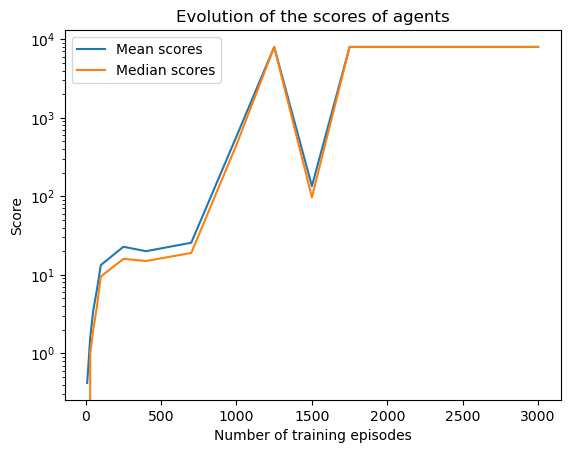

In [493]:
plt.plot(episodes_array, mean_scores, label="Mean scores")
plt.plot(episodes_array, median_scores, label="Median scores")

plt.title("Evolution of the scores of agents")

plt.xlabel("Number of training episodes")
plt.ylabel("Score")

plt.yscale('log')

plt.legend()

plt.show()

We get convergence towards the optimal policy after 2000 episodes. To set a benchmark for the agent in order to test the convergence and performances, we will train a model for 5000 episodes to allow a certain margin.

### Convergence rate and impact of parameters

In [15]:
def examine_parameter_combination(alpha, epsilon, gamma, i_lim, n_plays=20):
    height = 15
    width = 20
    pipe_gap = 4

    env = gym.make('TextFlappyBird-v0', 
                   height = height, 
                   width = width, 
                   pipe_gap = pipe_gap)

    q_learning_v1 = Q_learning_flappy_bird_v1(env=env, 
                                              width = width, 
                                              height = height, 
                                              pipe_gap = pipe_gap)

    start_n_episodes = 10
    end_n_episodes = 3000
    n_steps = 40

    #episodes_array = np.linspace(start_n_episodes, end_n_episodes, n_steps).astype(int)
    episodes_array = [10, 30, 50, 75, 100, 250, 400, 700, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
    episodes_increments = [episodes_array[0]] + list(np.diff(episodes_array))


    median_scores = []
    mean_scores = []

    for i, n_episodes in enumerate(episodes_increments):
        train_model = q_learning_v1.train(n_episodes=n_episodes,
                                          alpha=alpha,
                                          epsilon=epsilon,
                                          gamma=gamma,
                                          i_lim=i_lim,
                                          show_episodes=False)
        
        scores = []
        for _ in range(n_plays):
            model = train_model.play(False)
            scores.append(model.score_play)


        median_scores.append(np.median(scores))
        mean_scores.append(np.mean(scores))
    
    return median_scores, mean_scores

In [16]:
alpha = 0.1
epsilon = 0.1
gamma = .9

median_scores, mean_scores = examine_parameter_combination(alpha, epsilon, gamma, 2000, n_plays=1)

In [36]:
def hyperparameter_tuning(alpha_range, epsilon_range, gamma_range, i_max_range, n_trains=10, n_plays=20):
    if type(alpha_range) == int or type(alpha_range) == float:
        alpha_range = [alpha_range]
    if type(epsilon_range) == int or type(epsilon_range) == float:
        epsilon_range = [epsilon_range]
    if type(gamma_range) == int or type(gamma_range) == float:
        gamma_range = [gamma_range]
    if type(i_max_range) == int or type(i_max_range) == float:
        i_max_range = [i_max_range]
    
    
    param_combinations = list(product(alpha_range, epsilon_range, gamma_range, i_max_range))
    
    result_dict = {'combinations' : [],
                   'alpha' : [],
                   'epsilon' : [],
                   'gamma' : [],
                   'i_max' : [],
                   'mean_score' : [],
                   'median_score' : [],
                   }
    
    for alpha, epsilon, gamma, i_max in tqdm(param_combinations, disable=False):
        
        #print(alpha, epsilon, gamma, i_max)
        
        mean_score_array_comb = []
        median_score_array_comb = []
        
        for _ in range(n_trains):
            median_scores_comb, mean_scores_comb = examine_parameter_combination(alpha, 
                                                                                epsilon, 
                                                                                gamma, 
                                                                                i_max,
                                                                                n_plays=n_plays,
                                                                                )
            mean_score_array_comb.append(mean_scores_comb)
            median_score_array_comb.append(median_scores_comb)
        
        mean_score_array_comb = np.mean(np.array(mean_score_array_comb), axis=0)
        median_score_array_comb = np.mean(np.array(median_score_array_comb), axis=0)
        
        result_dict['combinations'].append((alpha, epsilon, gamma, i_max))
        result_dict['alpha'].append(alpha)
        result_dict['epsilon'].append(epsilon)
        result_dict['gamma'].append(gamma)
        result_dict['i_max'].append(i_max)
        result_dict['mean_score'].append(mean_score_array_comb)
        result_dict['median_score'].append(median_score_array_comb)
    
    return result_dict
    

In [37]:
alpha_range = np.linspace(0.2, 1, 4)
epsilon_range = [0.01, 0.1]
gamma_range = [0.8, 0.9, 1]
i_max_range = [1500, 2000]

n_trains = 10
n_plays = 10

result_dict = hyperparameter_tuning(alpha_range, 
                                    epsilon_range, 
                                    gamma_range, 
                                    i_max_range, 
                                    n_trains = n_trains, 
                                    n_plays = n_plays)


100%|████████████████████████████████████████| 48/48 [3:22:50<00:00, 253.56s/it]


In [38]:
result_df = pd.DataFrame(result_dict)
result_df

,combinations,alpha,epsilon,gamma,i_max,mean_score,median_score
0,"(0.2, 0.01, 0.8, 1500)",0.200000,0.01,0.8,1500,"[0.32, 2.08, 4.4, 7.15, 15.459999999999999, 27...","[0.25, 1.45, 3.0, 4.7, 9.85, 265.0, 1500.7, 18..."
1,"(0.2, 0.01, 0.8, 2000)",0.200000,0.01,0.8,2000,"[0.85, 1.54, 3.62, 6.82, 30.099999999999994, 2...","[0.6, 1.15, 2.95, 5.65, 23.1, 240.45, 1896.45,..."
2,"(0.2, 0.01, 0.9, 1500)",0.200000,0.01,0.9,1500,"[0.63, 2.59, 6.88, 13.290000000000001, 22.1699...","[0.45, 2.0, 5.95, 8.4, 17.6, 379.5, 1347.3, 16..."
3,"(0.2, 0.01, 0.9, 2000)",0.200000,0.01,0.9,2000,"[0.99, 1.52, 5.07, 10.98, 9.04, 519.0799999999...","[0.85, 1.1, 3.95, 7.25, 6.05, 488.6, 1794.15, ..."
4,"(0.2, 0.01, 1, 1500)",0.200000,0.01,1.0,1500,"[1.23, 2.6000000000000005, 119.19000000000001,...","[1.0, 1.75, 104.05, 125.7, 227.3, 555.1, 759.0..."
5,"(0.2, 0.01, 1, 2000)",0.200000,0.01,1.0,2000,"[0.8, 3.72, 6.3100000000000005, 14.56999999999...","[0.5, 2.25, 3.95, 12.9, 51.45, 121.1, 500.85, ..."
6,"(0.2, 0.1, 0.8, 1500)",0.200000,0.10,0.8,1500,"[0.31, 1.0499999999999998, 1.6999999999999997,...","[0.05, 0.5, 1.4, 2.55, 2.25, 12.4, 230.95, 114..."
7,"(0.2, 0.1, 0.8, 2000)",0.200000,0.10,0.8,2000,"[0.8, 2.0199999999999996, 3.85, 4.979999999999...","[0.5, 1.5, 2.35, 4.25, 4.35, 15.8, 313.65, 136..."
8,"(0.2, 0.1, 0.9, 1500)",0.200000,0.10,0.9,1500,"[0.4, 1.22, 2.55, 7.55, 9.44, 41.2499999999999...","[0.3, 0.65, 1.6, 6.55, 7.2, 34.85, 125.55, 106..."
9,"(0.2, 0.1, 0.9, 2000)",0.200000,0.10,0.9,2000,"[0.44000000000000006, 1.18, 3.59, 6.45, 7.5100...","[0.15, 0.95, 2.1, 4.95, 4.85, 165.15, 140.15, ..."


In [49]:
result_df.to_csv("Hyperparameter results Q-Learning")

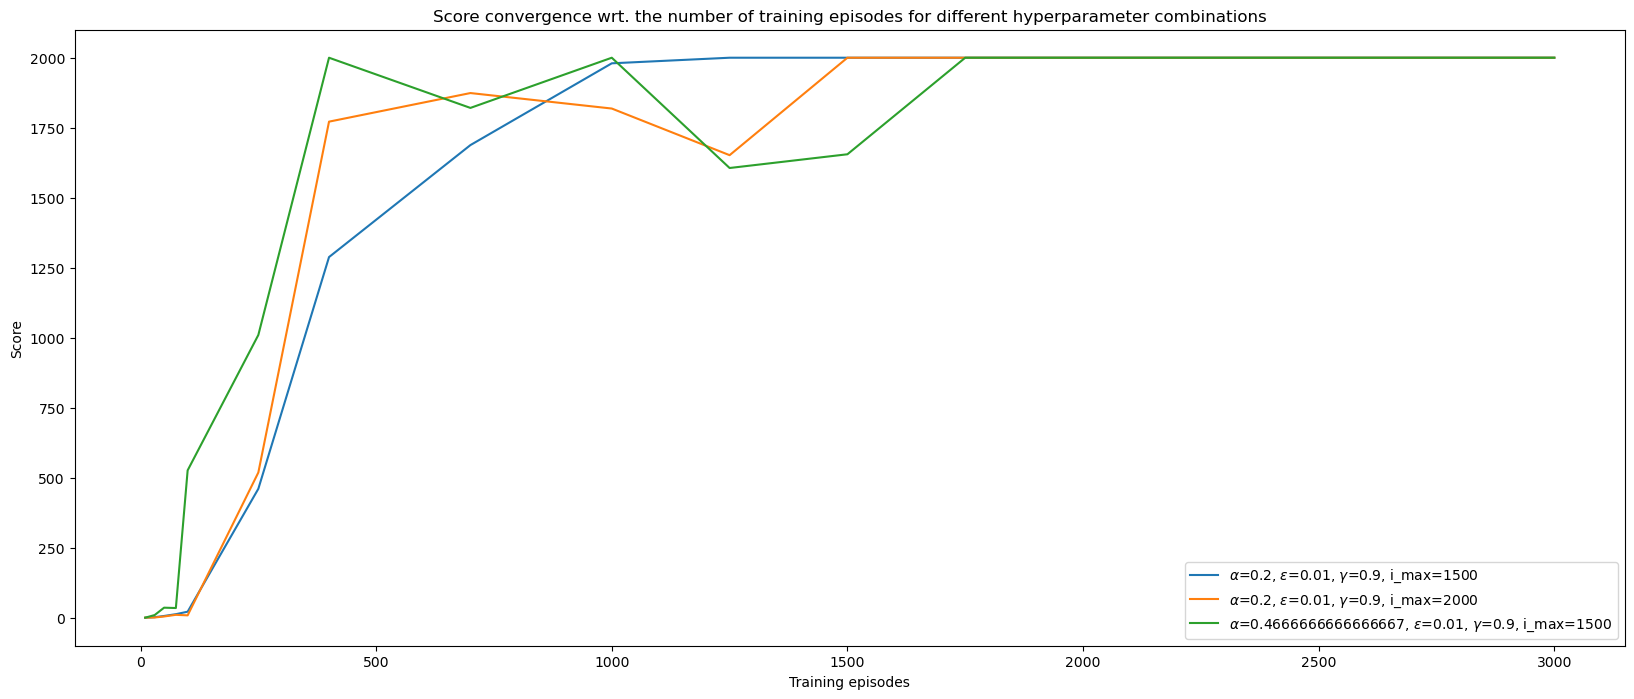

In [48]:
episodes_array = [10, 30, 50, 75, 100, 250, 400, 700, 1000, 1250, 1500, 1750, 2000, 2500, 3000]

for index, row in result_df.iterrows():
    alpha = row['alpha']
    epsilon = row['epsilon']
    gamma = row['gamma']
    i_max = row['i_max']
    
    median_score = row['median_score']
    mean_score = row['mean_score']
    
    instances_max = np.sum(np.array(mean_score) == 2000)
    
    if instances_max > 4 :
    
        label = fr"$\alpha$={alpha}, $\epsilon$={epsilon}, $\gamma$={gamma}, i_max={i_max}"

        plt.plot(episodes_array, mean_score, label=label)

plt.xlabel("Training episodes")
plt.ylabel("Score")

plt.title("Score convergence wrt. the number of training episodes for different hyperparameter combinations")

plt.legend()

plt.show()

First, we need to train a benchmark agent. As said before, we will train it on 5000 episodes.

To compare the different models, we will calculate the distance between the Q-values of the models and the Q-values of the benchmark.

In [187]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

In [292]:
alpha = 0.1
epsilon = 0.1
gamma = .9

benchmark_episodes = 5000

benchmark_agent = Q_learning_flappy_bird_v1(env=env, 
                                            width = width, 
                                            height = height, 
                                            pipe_gap = pipe_gap)
    
benchmark_agent = benchmark_agent.train(n_episodes=benchmark_episodes,
                                        alpha=alpha,
                                        epsilon=epsilon,
                                        gamma=gamma,
                                        show_episodes=False)

In [293]:
benchmark_policy = np.argmax(benchmark_agent.Q, axis=-1)
benchmark_policy = benchmark_policy[::-1, ::-1]

In [294]:
window = np.ones((4, 4))
window = window / window.size
benchmark_policy_average = convolve2d(benchmark_policy, window, mode='valid')

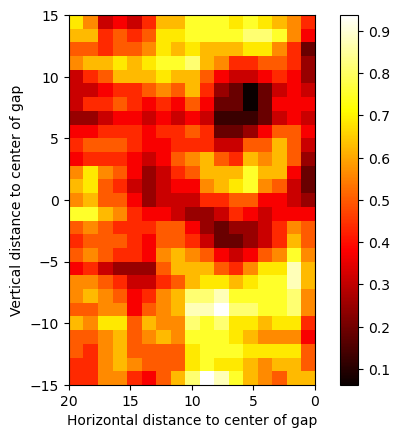

In [295]:
plt.imshow(benchmark_policy_average.T, cmap='hot', extent=extent)

extent = [20 , 0, -15 , 15]

plt.colorbar()

plt.xlabel("Horizontal distance to center of gap")
plt.ylabel("Vertical distance to center of gap")

plt.show()

In [ ]:
start_n_episodes = 10
end_n_episodes = 3000
n_steps = 20

episodes_array = np.linspace(start_n_episodes, end_n_episodes, n_steps).astype(int)
episodes_increments = [start_n_episodes] + list(np.diff(episodes_array))

raw_results = []
median_scores = []
mean_scores = []
dict_scores = {}

for i, n_episodes in enumerate(episodes_increments):
    train_model = q_learning_v1.train(n_episodes=n_episodes,
                                      alpha=alpha,
                                      epsilon=epsilon,
                                      gamma=gamma,
                                      Q_benchmark=
                                      show_episodes=False)

    n_plays = 100
    print(f"Training with {episodes_array[i]} episodes :")
    scores = []
    for _ in tqdm(range(n_plays)):
        model = train_model.play(False, sleep_time=0)
        scores.append(model.score_play)
        raw_results.append(model.score_play)
    
    dict_scores[episodes_array[i]] = scores
        
    median_scores.append(np.median(scores))
    mean_scores.append(np.mean(scores))

#### Performance review

In [128]:
def examine_parameter_combination(alpha, epsilon, gamma, n_episodes_train=100, n_episodes_test=100):
    
    model = Q_learning_flappy_bird_v1(env=env, 
                                     width = width, 
                                     height = height, 
                                     pipe_gap = pipe_gap)
    
    model = model.train(n_episodes=n_episodes_train,
                        alpha=alpha,
                        gamma=gamma,
                        epsilon=epsilon,
                        show_episodes=False)

    rewards = []
    
    for i in tqdm(range(n_episodes_test), disable=True):
        played_model = model.play(False)
        rewards.append(played_model.reward_play)
    
    return rewards
    
    

In [129]:
def hyperparameter_optimization(alpha_range, epsilon_range, gamma_range):
    if type(alpha_range) == int or type(alpha_range) == float:
        alpha_range = [alpha_range]
    if type(epsilon_range) == int or type(epsilon_range) == float:
        epsilon_range = [epsilon_range]
    if type(gamma_range) == int or type(gamma_range) == float:
        gamma_range = [gamma_range]
    
    mean_rewards = []
    std_rewards = []
    median_rewards = []
    
    param_combinations = list(product(alpha_range, epsilon_range, gamma_range))
    
    
    for alpha, epsilon, gamma in tqdm(param_combinations, disable=False):
        total_rewards = []
        for _ in range(100):
            rewards = examine_parameter_combination(alpha, 
                                                    epsilon, 
                                                    gamma, 
                                                    n_episodes_train=50,
                                                    n_episodes_test=50)
            total_rewards += rewards
            
        mean_rewards.append(np.mean(rewards))
        std_rewards.append(np.std(rewards))
        median_rewards.append(np.median(rewards))
    
    result_dict = {'combinations' : param_combinations,
                   'mean_rewards' : mean_rewards,
                   'std_rewards' : std_rewards,
                   'median_rewards' : median_rewards,
                  }
    
    return result_dict
    

In [142]:
alpha_range = np.linspace(0.001, 1, 5)
epsilon_range = [0.01, 0.1]
gamma_range = [0.9, 1]

result = hyperparameter_optimization(alpha_range, epsilon_range, gamma_range)

 35%|██████████████████████████████████████▏                                                                      | 7/20 [2:20:14<4:20:26, 1202.04s/it]


KeyboardInterrupt: 

In [135]:
argmax_mean = np.argmax(result['mean_rewards'])
best_hyper = result['combinations'][argmax_mean]
best_hyper

(0.25075, 0.1, 0.9)

In [136]:
n_alpha = len(alpha_range)
n_epsilon = len(epsilon_range)
n_gamma = len(gamma_range)

shape = (n_alpha, n_epsilon, n_gamma)

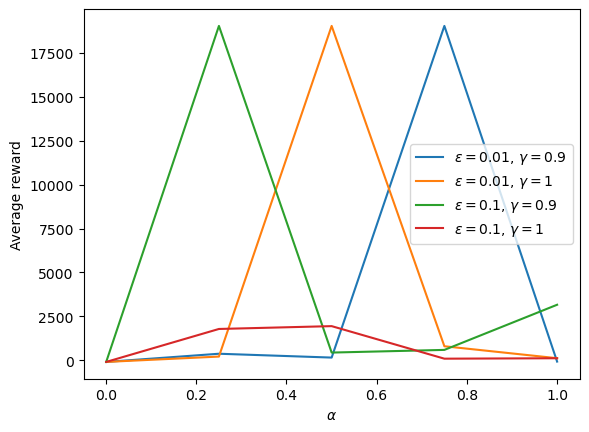

In [137]:
mean_array = np.array(result['mean_rewards']).reshape(shape)
std_array = np.array(result['std_rewards']).reshape(shape)
median_array = np.array(result['median_rewards']).reshape(shape)

for i in range(len(epsilon_range)):
    for j in range(len(gamma_range)):
        epsilon = epsilon_range[i]
        gamma = gamma_range[j]

        alpha_mean_array = median_array[:, i, j]
        
        

        plt.plot(alpha_range, alpha_mean_array, label=f"$\epsilon = {epsilon}$, $\gamma = {gamma}$")

plt.xlabel(r"$\alpha$")
plt.ylabel("Average reward")

plt.legend()
plt.show()

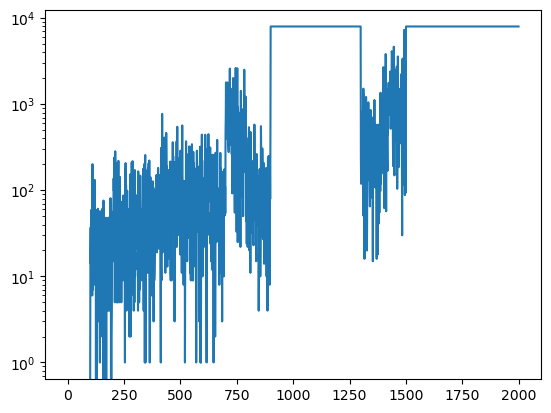

In [120]:
plt.plot(raw_results)
plt.yscale('log')
plt.show()

In [121]:
q_learning_v1.death_cause_play

'Floor'

In [122]:
dict_scores

{10: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 167: [1,
  19,
  37,
  14,
  59,
  12,
  19,
  17,
  20,
  6,
  201,
  7,
  17,
  15,
  14,
  21,
  13,
  8,
  56,
  13,
  132,
  23,
  21,
  49,
  31,
  55,
  0,
  13,
  0,
  59,
  14,
  9,
  21,
  6,
  61,
  3,
  58,
  4,
  19,
  21,
  10,
  33,
  8,
  1,
  20,
  57,
  24,
  2,
  15,
  11,
  6,
  3,
  36,
  13,
  61,
  20,
  18,
  68,
  0,
  76,
  17,
  16,
  19,
  0,
  0,
  27,
  3,
  39,
  45,
  0,
  48,
  0,
  17,
  5,
  5,
  14,
  24,
  27,
  47,
  4,
  29,
  48,
  47,
  44,
  48,
  

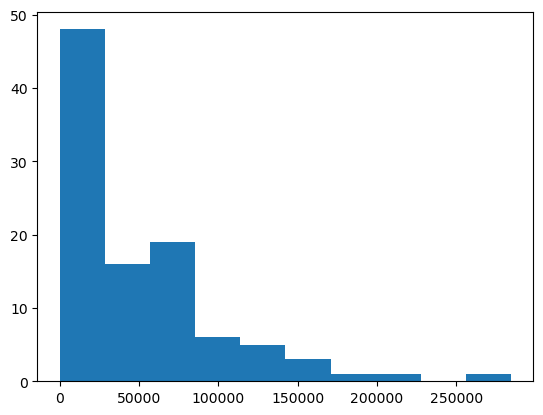

In [31]:
plt.hist(scores, bins=10)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (173,) and (1951,)

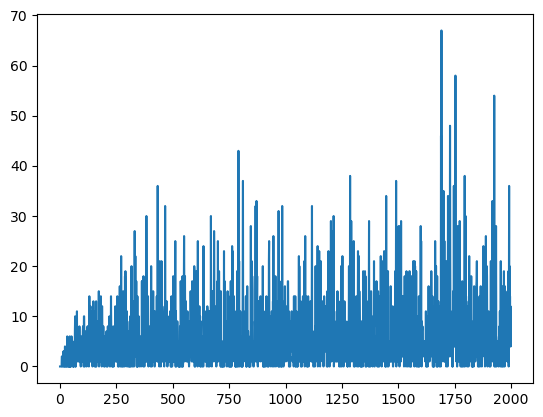

In [32]:
plt.plot(q_learning_v1.score_history, label='True scores')

window_size = 50
moving_average_scores = np.convolve(q_learning_v1.score_history, np.ones(window_size), 'valid') / window_size
plt.plot(list(range(n_episodes))[window_size-1:], moving_average_scores, label="Moving average")

plt.xlabel("Episode")
plt.ylabel("Score")

plt.legend()

plt.show()

The distribution of scores :

In [54]:
n_experiments = 1000

experiment_scores = []
experiment_death_cause = []

for i in tqdm(range(n_experiments)):
    model = q_learning_v1.play(False)
    experiment_scores.append(model.score_play)
    experiment_death_cause.append(model.death_cause_play)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.09it/s]


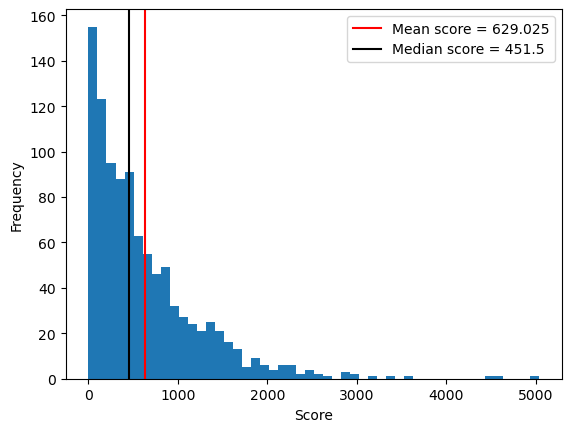

In [55]:
plt.hist(experiment_scores, bins=50)

mean_score = np.mean(experiment_scores)
median_score = np.median(experiment_scores)

plt.axvline(mean_score, color='r', label=f"Mean score = {mean_score}")
plt.axvline(median_score, color='k', label=f"Median score = {median_score}")


plt.xlabel("Score")
plt.ylabel("Frequency")

plt.legend()

plt.show()

Let's examine the causes of death.

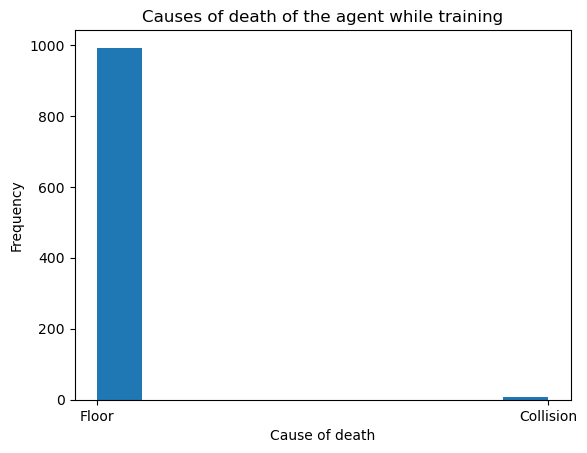

In [10]:
plt.hist(q_learning.death_causes)

plt.title("Causes of death of the agent while training")

plt.xlabel("Cause of death")
plt.ylabel("Frequency")

plt.show()

In [12]:
q_learning.play()

Text Flappy Bird!
Score: 22
----------------------
[         |          ]
[         |          ]
[      @             ]
[                    ]
[                    ]
[                    ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=3,dy=-2)


KeyboardInterrupt: 

### Distance to the next pipe gap and to the floor

So as to avoid the collisitions with the floor, we will add another dimension to our state space that incapsulses the information of the distance to the groud. The implementation will be very similar to what we did before in `Q_learning_flappy_bird_v1`.

In [13]:
class Q_learning_flappy_bird_v2():
    def __init__(self, env, width, height, pipe_gap):
        
        self.width = width
        self.height = height
        self.pipe_gap = pipe_gap
        self.env = env
        
        n_x_states = self.width
        n_y_states = 2 * self.height
        n_h_states = self.height
        self.state_space_x = list(range(self.width))
        self.state_space_y = list(range(-self.height, self.height))
        self.state_space_h = list(range(1, self.height + 1))
        
        self.Q = np.random.rand(n_x_states, n_y_states, n_h_states, 2) * 10
        # Terminal conditions
        self.Q[0, :, :, :] = 0      # x = 0
        self.Q[:, :, -1, :] = 0     # h = 15 the height is measured from the top-down
        
        self.score_history = []
        self.death_causes = []
        
        self.death_cause_play = None
        self.score_play = None
    
    
    def _distance_to_state(self, x, y, h):
        """
        Returns the index of the state given distances x and y.
        """
        state_x = self.state_space_x.index(x)
        state_y = self.state_space_y.index(y)
        state_h = self.state_space_h.index(h)
        return state_x, state_y, state_h
    
    
    def _argmax(self, q_values):
        """
        Returns the argmax equiprobably in case of ties.
        """
        top = float("-inf")
        
        ties = []
        for i in range(len(q_values)):
            if q_values[i] == top:
                ties.append(i)
            elif q_values[i] > top:
                ties = [i]
                top = q_values[i]
        
        ind = np.random.choice(ties)
        return ind

    
    def train(self, n_episodes, alpha, epsilon, show_episodes=True):
        """
        Trains the Q-Learning model.
        """
        top_score = float("-inf")
        
        for i in range(n_episodes):
            obs = self.env.reset()
            x, y = obs[0]
            h = 8
            x, y, h = self._distance_to_state(x, y, h)
            
            while True:
                # Select next action
                random_number = np.random.random()
                if random_number < epsilon:
                    action = self.env.action_space.sample()  # for an agent, action = agent.policy(observation)
                else:
                    action = self._argmax(self.Q[x, y, h, :])

                # Apply action and return new observation of the environment
                obs, reward, done, _, info = self.env.step(action)
                x_, y_ = obs
                h_ = info['player'][1]
                score = info['score']
                if score > top_score:
                    top_score = score
                
                # If we die, we set the reward to -100.
                # If we manage to go through a gap, we set the reward to 10
                if done:
                    reward = -100
                    if x == 0:
                        self.death_causes.append("Collision")
                    elif h == self.height - 1:
                        self.death_causes.append("Floor")
                    else:
                        self.death_causes.append("Bizarre")
                elif x==0 and not done:
                    reward = 10
                
                self.Q[x, y, action] += alpha * (reward + np.max(self.Q[x_, y_, :] - self.Q[x, y, action]))
                
                x, y, h = x_, y_, h_
                
                # Render the game
                if show_episodes:
                    os.system("clear")
                    print(f"Episode : {i+1}/{n_episodes}")
                    print("Top score :", top_score)
                    sys.stdout.write(self.env.render())
                    #time.sleep(.01) # FPS

                    clear_output(wait=True)

                # If player is dead break
                if done:
                    break
            
            self.score_history.append(score)

        self.env.close()
        
        return self
    
    
    def play(self, show_episodes=True):
        obs = self.env.reset()
        x, y = obs[0]
        h = 8
        x, y, h = self._distance_to_state(x, y, h)

        while True:
            # Select next action
            action = self._argmax(self.Q[x, y, h, :])

            # Apply action and return new observation of the environment
            obs, reward, done, _, info = self.env.step(action)
            x, y = obs
            h = info['player'][1]
            
            if done:
                if x == 0:
                    self.death_cause_play = "Collision"
                elif h == self.height - 1:
                    self.death_cause_play = "Floor"
            
            # Render the game
            if show_episodes:
                os.system("clear")
                sys.stdout.write(env.render())
                time.sleep(.1) # FPS

                clear_output(wait=True)

            # If player is dead break
            if done:
                self.score_play = info['score']
                break

        env.close()
    
        return self
        
        

In [14]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

q_learning_v2 = Q_learning_flappy_bird_v1(env=env, 
                                         width = width, 
                                         height = height, 
                                         pipe_gap = pipe_gap)

In [ ]:
n_episodes = 500
alpha = 0.1
epsilon = 0.1

train_model_2 = q_learning_v2.train(n_episodes=n_episodes,
                                    alpha=alpha,
                                    epsilon=epsilon)

Episode : 157/1000
Top score : 258
Text Flappy Bird!
Score: 21
----------------------
[       |         |  ]
[       |         |  ]
[       |            ]
[       |            ]
[       |            ]
[       |            ]
[       |         |  ]
[       |         |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=1,dy=1)
Episode : 157/1000
Top score : 258
Text Flappy Bird!
Score: 21
----------------------
[       |         |  ]
[       |         |  ]
[       |            ]
[       |            ]
[       |            ]
[       |            ]
[       |         |  ]
[       |         |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe 

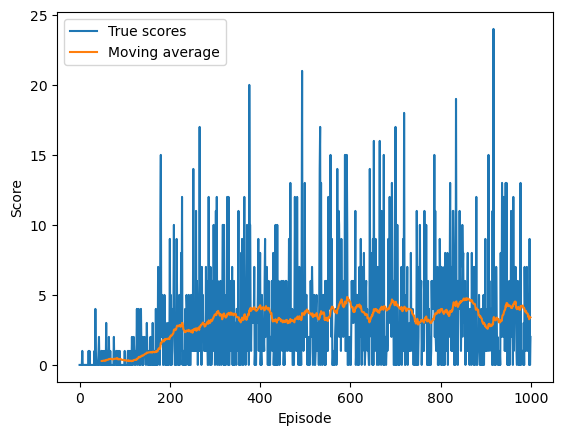

In [25]:
plt.plot(q_learning_v2.score_history, label='True scores')

window_size = 50
moving_average_scores = np.convolve(q_learning_v2.score_history, np.ones(window_size), 'valid') / window_size
plt.plot(list(range(n_episodes))[window_size-1:], moving_average_scores, label="Moving average")

plt.xlabel("Episode")
plt.ylabel("Score")

plt.legend()

plt.show()

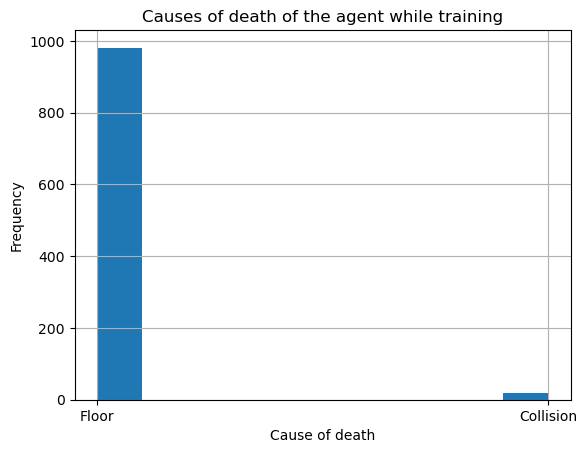

In [28]:
plt.hist(q_learning_v2.death_causes)

plt.title("Causes of death of the agent while training")

plt.xlabel("Cause of death")
plt.ylabel("Frequency")

plt.grid()

plt.show()

In [29]:
q_learning_v2.play()

Text Flappy Bird!
Score: 25
----------------------
[   |         |      ]
[   |         |      ]
[   |         |      ]
[      @      |      ]
[             |      ]
[             |      ]
[             |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |                ]
[   |                ]
[   |                ]
[   |                ]
[   |         |      ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=7,dy=-9)


KeyboardInterrupt: 

In [32]:
q_learning_v2.env.close()